### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [3]:
from tensorflow.keras import models, layers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [4]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 40
num_filter = 12
compression = 1
dropout_rate = 0.0

In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
image_height, image_width, channel_size = X_train.shape[1],X_train.shape[2],X_train.shape[3]
# convert to one hot encoing
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 4s 0us/step


In [6]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [8]:
def plot_sample(X, y, index):
  plt.figure(figsize = (15,2))
  plt.imshow(X[index])
  plt.xlabel(classes[y[index]])

In [9]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [10]:
(X_train_plot, y_train_plot), (X_test_plot, y_test_plot) = tf.keras.datasets.cifar10.load_data()

In [11]:
y_train_plot = y_train_plot.reshape(-1,)
y_train_plot[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

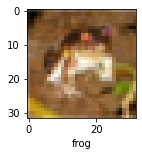

In [12]:
plot_sample(X_train_plot, y_train_plot, 0)

In [13]:
#Normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

In [15]:
X_train[0].shape

(32, 32, 3)

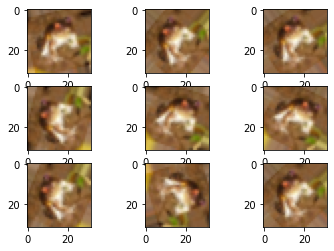

In [16]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
image = expand_dims(X_train[0], 0)
dg = ImageDataGenerator(rotation_range=90)
it = dg.flow(image, batch_size=1)
for i in range(9):
  plt.subplot(330 + 1 + i) #330 means 3x3 grid and 1+i shifts the place of augmented image
  batch = it.next()
  img = batch[0];
  plt.imshow(img)
plt.show()

In [17]:
from keras import regularizers

In [18]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  temp = input
  for _ in range(l):
    BatchNorm = layers.BatchNormalization()(temp)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
    concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
    temp = concat
  return temp
## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
  if dropout_rate>0:
    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
  avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
  return avg
#output layer

In [19]:
def output_layer(input):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
  flat = layers.Flatten()(AvgPooling)
  output = layers.Dense(num_classes, activation='softmax')(flat)
  return output

In [20]:
tf.keras.backend.clear_session()

In [21]:
dropout_rate = 0
num_filter = 30
l = 7
input = layers.Input(shape=(image_height, image_width, channel_size,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)
#BatchNorm = layers.BatchNormalization()(First_Conv2D)
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)
Last_Block = denseblock(Third_Transition, num_filter, dropout_rate)
output = output_layer(Last_Block)

2022-04-07 06:35:05.266589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 06:35:05.355720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 06:35:05.356459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 06:35:05.357530: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
optimizer=Adam(),
metrics=['accuracy'])

In [24]:
model.metrics_names

[]

In [25]:
dg = ImageDataGenerator(height_shift_range=0.1, width_shift_range= 0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [26]:
dg.fit(X_train)

In [27]:
#method to connect to google drive
! conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.10.0      |     pyha770c72_0          77 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_2         145 KB  conda-forge
    conda-4.12.0               |   py37h89c1867_0         1.0 MB  conda-forge
    filelock-3.6.0             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    openssl-1.1.1n             |       h166bdaf_0         2.1 MB  conda-forge
    soupsieve-2.3.1            |     pyhd8ed1ab_0          33 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  beautifu

In [28]:
 #downloading file from google drive [copy token of file form goodle drive link file]
    !gdown --id  1olzpoAcvPSIK-9qE5w2PQu47C8n2lfx2

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1olzpoAcvPSIK-9qE5w2PQu47C8n2lfx2 



In [29]:
model.load_weights('../input/weights/model_best_weights.h5')

#!kaggle datasets download -d ashishkumarrai/weights

In [30]:
#https://stackoverflow.com/questions/47814809/fit-generator-to-save-model-with-least-validation-loss
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [38]:
#how to upload weights
#https://www.kaggle.com/questions-and-answers/92749
#how to download weights
#https://www.kaggle.com/discussions/getting-started/145864
it = dg.flow(x=X_train, y=y_train, batch_size=batch_size)
step_sze = X_train.shape[0]//batch_size
model1 = model.fit_generator(it, steps_per_epoch=step_sze, epochs=70,verbose=1, validation_data=(X_test, y_test), callbacks = [early_stop,checkpoint])

Epoch 1/70
390/390 [==============================] - 38s 98ms/step - loss: 0.0654 - accuracy: 0.9769 - val_loss: 0.4431 - val_accuracy: 0.8972

Epoch 00001: loss did not improve from 0.06442
Epoch 2/70
390/390 [==============================] - 37s 96ms/step - loss: 0.0632 - accuracy: 0.9785 - val_loss: 0.4189 - val_accuracy: 0.9068

Epoch 00002: loss improved from 0.06442 to 0.06318, saving model to model_best_weights.h5
Epoch 3/70
390/390 [==============================] - 38s 96ms/step - loss: 0.0628 - accuracy: 0.9776 - val_loss: 0.4841 - val_accuracy: 0.8930

Epoch 00003: loss improved from 0.06318 to 0.06280, saving model to model_best_weights.h5
Epoch 4/70
390/390 [==============================] - 37s 96ms/step - loss: 0.0636 - accuracy: 0.9775 - val_loss: 0.4290 - val_accuracy: 0.8951

Epoch 00004: loss did not improve from 0.06280
Epoch 5/70
390/390 [==============================] - 38s 97ms/step - loss: 0.0601 - accuracy: 0.9788 - val_loss: 0.4286 - val_accuracy: 0.9014

E

In [39]:
metrics = model.evaluate(x= X_test, y= y_test, verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 0.3928 - accuracy: 0.9079


In [40]:
print("test accuracy: ", metrics[1])

test accuracy:  0.9078999757766724


In [41]:
#how to save with codes output in  kaggle note book
#select save version >select quick save >open you rcode for your work in new tab> download your code